# Multi-Label Classification of food items with Fast AI

In [1]:
from fastai.vision.all import *
from pathlib import Path

## Get data

In [2]:
data_dir = Path("/kaggle/input/food-recognition-coco/data")
train_dir = data_dir/"train"
valid_dir = data_dir/"validation"

In [3]:
train_imgs, train_lbl_bbox = get_annotations(train_dir/"annotations.json")
valid_imgs, valid_lbl_bbox = get_annotations(valid_dir/"annotations.json")

In [4]:
train_imgs = [f"train/images/{i}" for i in train_imgs]
valid_imgs = [f"validation/images/{i}" for i in valid_imgs]
train_imgs[0], valid_imgs[0]

('train/images/131072.jpg', 'validation/images/149022.jpg')

In [5]:
train_labels = list(map(lambda x: x[1], train_lbl_bbox))
valid_labels = list(map(lambda x: x[1], valid_lbl_bbox))
train_labels[:5]

[['bread_wholemeal', 'jam'],
 ['water'],
 ['bread', 'banana'],
 ['soft_cheese',
  'ham_raw',
  'hard_cheese',
  'bread_wholemeal',
  'cottage_cheese',
  'bread'],
 ['coffee']]

In [6]:
train_data = {"name": train_imgs, "labels": train_labels, "is_valid": False}
valid_data = {"name": valid_imgs, "labels": valid_labels, "is_valid": True}
train_df = pd.DataFrame(train_data)
valid_df = pd.DataFrame(valid_data)
df = pd.concat([train_df, valid_df], ignore_index=True)
len(df)

55338

In [7]:
df.head()

,name,labels,is_valid
0,train/images/131072.jpg,"[bread_wholemeal, jam]",False
1,train/images/131087.jpg,[water],False
2,train/images/131088.jpg,"[bread, banana]",False
3,train/images/131094.jpg,"[soft_cheese, ham_raw, hard_cheese, bread_wholemeal, cottage_cheese, bread]",False
4,train/images/131096.jpg,[coffee],False


In [8]:
df.tail()

,name,labels,is_valid
55333,validation/images/117728.jpg,[hard_cheese],True
55334,validation/images/113813.jpg,[tomato],True
55335,validation/images/155034.jpg,"[tomato, salmon, shoots_n_s, onion]",True
55336,validation/images/166752.jpg,[strawberries],True
55337,validation/images/136988.jpg,"[bread, jam]",True


## Clean Data

Remove images with more than 3 items

In [9]:
df = df[df["labels"].apply(len) <= 3]
len(df)

49833

Remove very specific categories

In [10]:
def has_too_specific_category(labels):
    for l in labels:
        if len(l) > 12:
            return True
    return False


df = df[df["labels"].apply(has_too_specific_category) != True]
len(df)

32024

In [11]:
def fix_bread(labels):
    to_replace = ['bread_black', 'bread_grain', 'bread_rye', 'bread_toast', 'bread_white']
    return [l if l not in to_replace else "bread" for l in labels]


df["labels"] = df["labels"].apply(fix_bread)

In [12]:
df = df.reset_index(drop=True)
df

,name,labels,is_valid
0,train/images/131087.jpg,[water],False
1,train/images/131088.jpg,"[bread, banana]",False
2,train/images/131096.jpg,[coffee],False
3,train/images/131097.jpg,"[fruit_mixed, pancake, soft_cheese]",False
4,train/images/131098.jpg,"[pancake, soft_cheese]",False
...,...,...,...
32019,validation/images/180768.jpg,[water],True
32020,validation/images/117728.jpg,[hard_cheese],True
32021,validation/images/113813.jpg,[tomato],True
32022,validation/images/166752.jpg,[strawberries],True


## Prepare Datablock

In [13]:
def get_x(o):
    return data_dir/o["name"]

def get_y(o):
    return o["labels"]

In [14]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

In [15]:
dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    splitter=splitter,
    get_x=get_x, 
    get_y=get_y,
    item_tfms = RandomResizedCrop(128, min_scale=0.35)
)

dls = dblock.dataloaders(df)

In [16]:
dls.vocab

['alfa_sprouts', 'almonds', 'apple', 'apple_pie', 'applesauce', 'apricots', 'artichoke', 'asparagus', 'avocado', 'bacon', 'baked_potato', 'banana', 'banana_cake', 'basil', 'beans_kidney', 'beef_n_s', 'beer', 'beetroot_raw', 'berries_n_s', 'biscuit', 'black_olives', 'blueberries', 'bouillon', 'bread', 'bread_fruit', 'bread_pita', 'brioche', 'broccoli', 'brownie', 'bulgur', 'butter', 'cake_lemon', 'capers', 'cappuccino', 'carrot', 'cashew_nut', 'cauliflower', 'celeriac', 'cervelat_ch', 'cheese_n_s', 'cheesecake', 'cherries', 'chestnuts_ch', 'chicken', 'chicken_leg', 'chickpeas', 'coconut', 'coffee', 'cookies', 'cordon_bleu', 'corn', 'corn_crisps', 'couscous', 'crisp_bread', 'crisps_ch', 'croissant', 'croutons', 'cucumber', 'damson_plum', 'dates', 'egg', 'espresso', 'fennel', 'feta', 'figs', 'fish_n_s', 'flakes', 'focaccia', 'fondue', 'french_beans', 'fruit_coulis', 'fruit_mixed', 'fruit_tart', 'garlic', 'grapes', 'greek_salad', 'green_olives', 'gruyere_ch', 'guacamole', 'halloumi', 'ham_

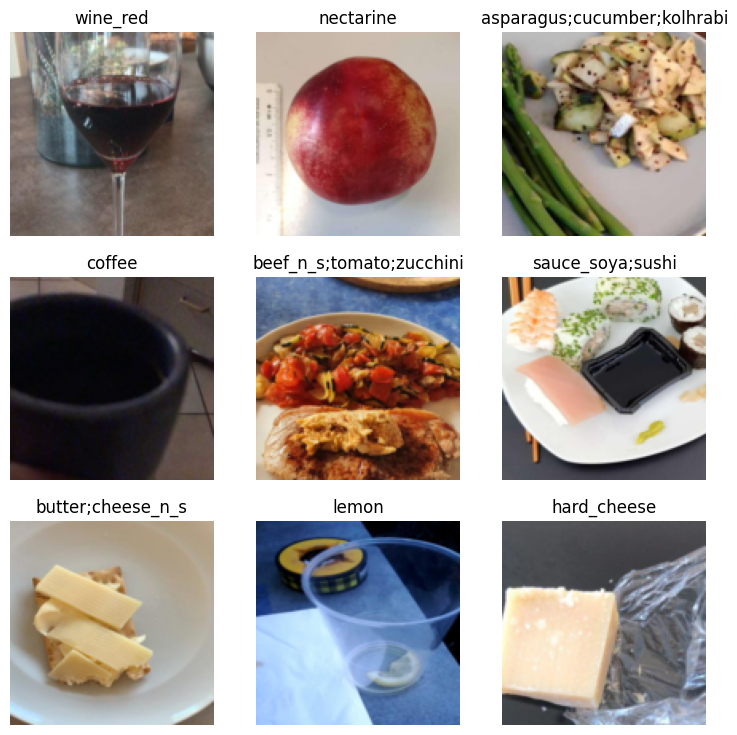

In [21]:
dls.show_batch()

## Train Model

In [38]:
learn = vision_learner(dls, resnet50, metrics=[PrecisionMulti(average="samples"), JaccardMulti(average="samples")])

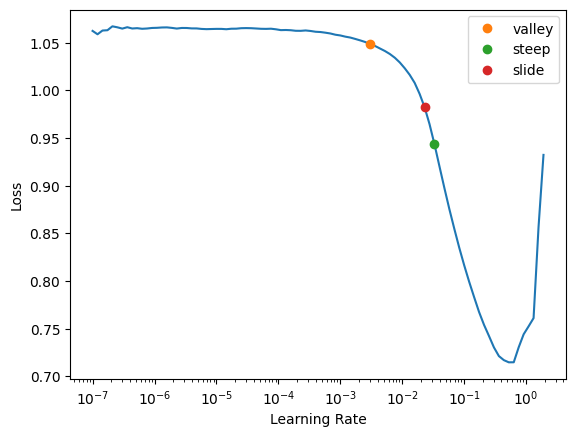

In [39]:
lr = learn.lr_find(suggest_funcs=(valley, steep, slide))

In [40]:
learn.fine_tune(10, base_lr=lr.valley)

epoch,train_loss,valid_loss,precision_score,jaccard_score,time
0,0.035674,0.027214,0.196532,0.188825,01:43


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,precision_score,jaccard_score,time
0,0.023563,0.020843,0.304432,0.286448,01:50
1,0.019206,0.016339,0.443160,0.410083,01:50
2,0.016506,0.013498,0.574823,0.537251,01:51
3,0.014621,0.011825,0.639049,0.590398,01:51
4,0.013183,0.010154,0.676943,0.634554,01:52
5,0.012409,0.009335,0.723186,0.678709,01:52
6,0.011173,0.008386,0.745183,0.702152,01:52
7,0.010225,0.007851,0.762364,0.718208,01:51
8,0.009973,0.007443,0.784522,0.736191,01:51
9,0.009504,0.007435,0.784522,0.737476,01:50


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


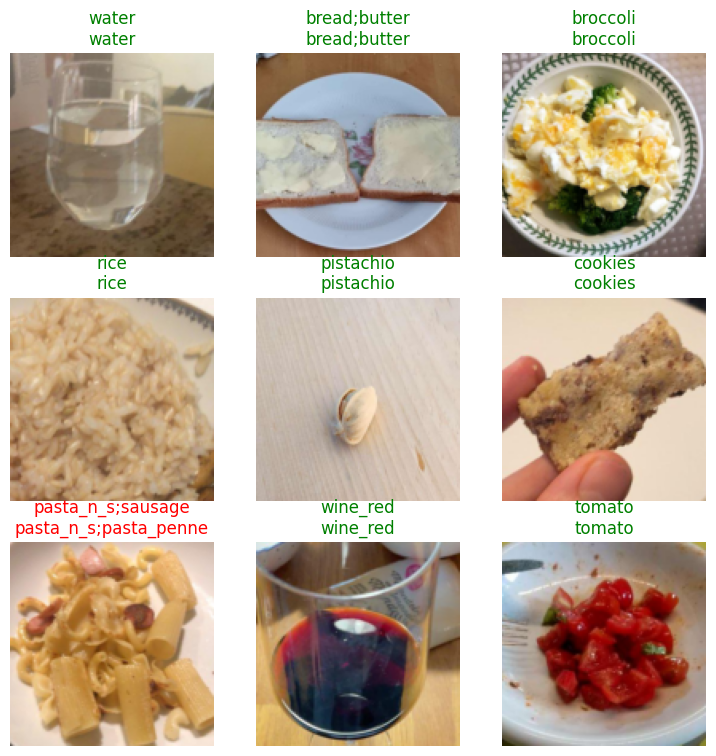

In [47]:
learn.show_results()

In [48]:
learn.export("model.pkl")

## Evaluation

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,target,predicted,probabilities,loss
0,french_beans;ham_raw;pasta_n_s,pasta_penne,"tensor([1.2942e-04, 9.4786e-04, 3.5186e-04, 1.9460e-04, 2.6825e-04, 2.4813e-05,\n 3.6470e-05, 5.6156e-03, 1.5999e-03, 2.5513e-02, 5.2598e-03, 5.5646e-05,\n 8.9472e-06, 2.1666e-03, 4.2319e-04, 9.0759e-03, 6.3095e-05, 1.5697e-03,\n 4.1038e-05, 5.8861e-05, 1.3642e-03, 1.2635e-05, 2.4863e-04, 1.8599e-03,\n 2.3947e-05, 1.8931e-04, 1.0123e-04, 2.1762e-03, 6.7831e-06, 3.0230e-04,\n 7.4393e-04, 1.3628e-05, 1.9761e-04, 1.6531e-05, 1.2308e-02, 1.8395e-04,\n 2.5444e-04, 2.0161e-03, 4.6924e-03, 4.9668e-02, 2.4059e-05, 1.1237e-05,\n 3.3861e-05, 6.0180e-03, 3.6111e-04, 1.2737e-03, 1.0732e-04, 5.0559e-04,\n 2.8498e-06, 1.9181e-03, 2.1978e-04, 1.0334e-03, 1.8714e-04, 1.4487e-05,\n 3.6772e-04, 1.0385e-05, 1.0321e-04, 1.8945e-03, 1.2064e-04, 1.4911e-04,\n 1.3933e-02, 2.2214e-04, 4.8655e-03, 1.7265e-03, 1.2038e-05, 2.2281e-03,\n 1.1309e-04, 1.9986e-04, 8.0496e-05, 1.4948e-02, 1.0440e-04, 4.4068e-04,\n 1.8681e-04, 8.9319e-04, 2.1681e-05, 4.9393e-04, 1.7221e-03, 3.2061e-03,\n 2.7622e-04, 4.1702e-04, 7.0035e-03, 1.8202e-02, 1.2161e-03, 7.9129e-04,\n 5.7010e-05, 6.0955e-06, 9.1015e-05, 1.1466e-04, 6.6905e-05, 6.8011e-05,\n 1.2208e-04, 4.1055e-05, 4.4195e-06, 2.3556e-03, 6.5027e-05, 3.1470e-04,\n 2.7314e-03, 4.0050e-03, 6.8868e-04, 1.1469e-04, 6.8277e-05, 1.4541e-03,\n 2.6384e-03, 3.0710e-04, 7.0311e-05, 7.6272e-03, 7.1441e-05, 1.1792e-05,\n 4.3509e-03, 1.0890e-03, 2.8775e-04, 5.2530e-05, 1.1045e-03, 1.5040e-02,\n 5.7033e-04, 2.1223e-04, 3.4631e-02, 1.3065e-03, 3.5981e-01, 5.2883e-01,\n 2.7581e-03, 4.0429e-05, 2.7738e-04, 2.9877e-05, 8.0564e-06, 6.5226e-04,\n 3.8154e-04, 1.2558e-03, 3.1936e-04, 5.0442e-05, 1.2027e-04, 6.2388e-05,\n 1.0765e-03, 7.5086e-03, 3.3892e-04, 2.9249e-05, 2.7905e-03, 9.0575e-05,\n 3.1368e-04, 4.1548e-05, 3.0268e-02, 5.1497e-05, 1.5703e-03, 4.1231e-04,\n 3.4896e-03, 3.5385e-03, 2.5050e-03, 4.3430e-04, 1.6578e-02, 1.7930e-03,\n 1.4673e-02, 6.2280e-04, 4.3218e-03, 6.8978e-04, 1.0956e-03, 2.0897e-02,\n 3.6146e-05, 1.2897e-03, 2.4009e-04, 1.1851e-02, 4.5853e-05, 1.0559e-04,\n 2.1348e-04, 2.5157e-04, 9.3086e-03, 6.3453e-05, 3.6991e-04, 7.9015e-05,\n 1.7259e-05, 6.8827e-04, 6.4194e-03, 1.4716e-03, 3.4323e-05, 1.0076e-04,\n 1.7469e-04, 2.7768e-06, 2.6291e-03, 1.1170e-01, 4.6270e-01, 4.4141e-05,\n 2.0891e-03, 1.7975e-05, 2.8388e-05, 1.2226e-03, 1.2887e-04, 2.8991e-05,\n 3.7242e-05, 7.7981e-05, 1.3430e-04, 1.3974e-02])",0.05877917259931564
1,black_olives;tomato,,"tensor([4.5205e-05, 1.5920e-02, 5.5350e-03, 8.2728e-02, 6.5034e-04, 2.3852e-03,\n 5.5658e-04, 1.5997e-03, 8.2019e-05, 8.9143e-03, 2.7183e-04, 6.9857e-05,\n 6.1576e-03, 2.3013e-04, 4.6213e-04, 8.9872e-04, 5.0897e-05, 2.7912e-04,\n 6.4615e-03, 2.1299e-03, 1.1525e-02, 3.0334e-04, 8.4001e-05, 1.0842e-02,\n 1.7499e-02, 8.5099e-04, 2.0118e-02, 2.1262e-04, 4.2526e-03, 2.0159e-04,\n 1.9896e-03, 1.2536e-02, 1.4499e-03, 2.1694e-05, 2.3554e-03, 1.9159e-04,\n 8.5843e-05, 5.2164e-04, 2.4555e-04, 2.2074e-02, 2.2362e-01, 4.0485e-04,\n 1.7358e-04, 4.2051e-03, 1.3829e-04, 9.0114e-04, 1.3421e-04, 9.7270e-04,\n 1.7925e-04, 2.5436e-03, 1.7271e-04, 7.7125e-04, 4.2924e-04, 1.2181e-03,\n 2.1994e-04, 6.1543e-04, 5.1621e-04, 6.9097e-04, 7.8147e-05, 6.0356e-05,\n 2.5298e-04, 4.6174e-04, 2.8480e-04, 5.9317e-03, 1.3677e-04, 6.3274e-04,\n 3.7722e-04, 2.0832e-01, 5.0580e-05, 1.3108e-04, 1.6954e-03, 1.7756e-03,\n 1.6576e-01, 5.8092e-04, 3.3421e-04, 2.8952e-04, 7.9979e-04, 1.0440e-03,\n 6.2212e-04, 6.9437e-03, 1.5267e-03, 1.0912e-03, 2.3789e-04, 2.2980e-03,\n 1.3747e-02, 2.9412e-03, 7.5857e-04, 3.8743e-03, 5.6661e-04, 1.1237e-03,\n 1.1594e-04, 5.9835e-04, 7.6551e-05, 4.2248e-04, 1.4388e-04, 3.6878e-04,\n 1.7514e-03, 4.0231e-04, 5.7332e-04, 8.2580e-04, 6.8049e-04, 1.8952e-03,\n 1.6733e-04, 7.7911e-04, 2.6047e-03, 1.3062e-03, 3.2725e-04, 1.2020e-03,\n 1.3994e-04, 2.6075e-04, 8.9857e-04, 2.0498e-04, 4.3834e-04, 3.5924e-03,\n 6.0728e-04, 8.6348e-04, 4.3299e-04, 1.9670e-04, 7.1575e-04, 1.4920e-04,\n 1.3874e-04, 5.5986e-04, 8.0149e-0

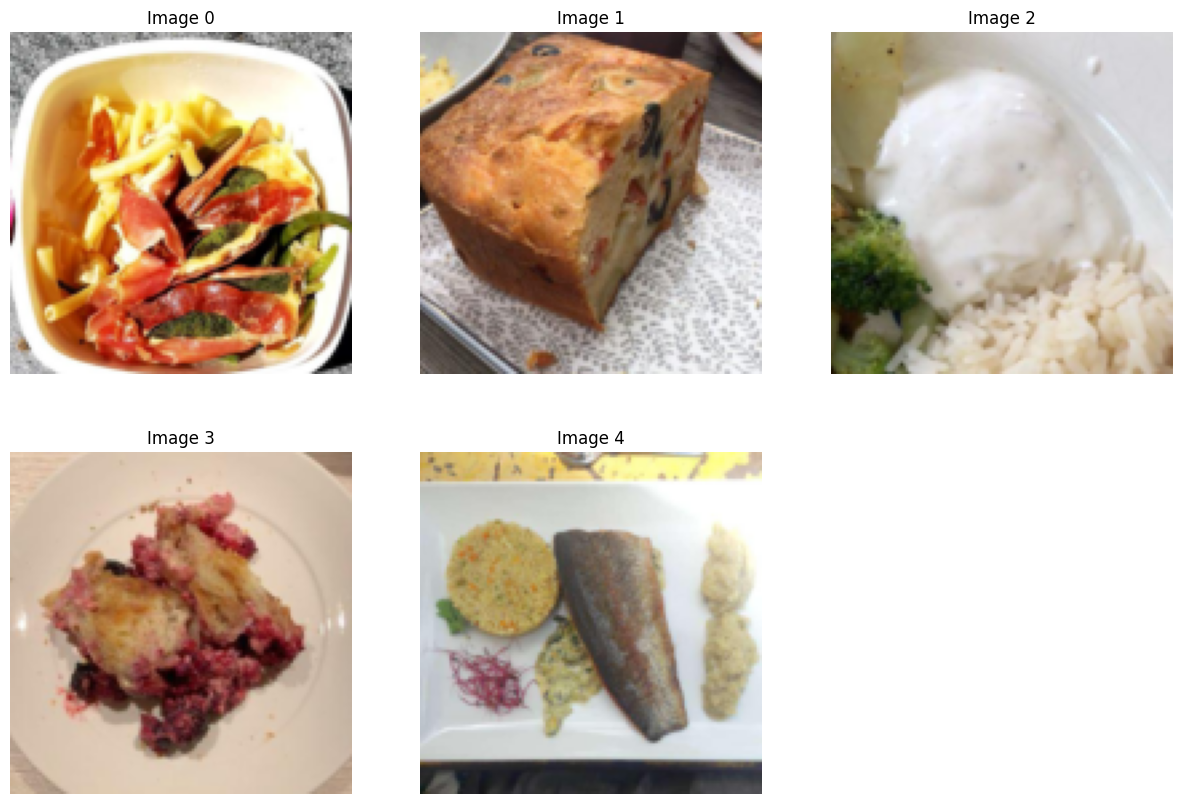

In [49]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(5, figsize=(15,10))

In [51]:
from sklearn.metrics import multilabel_confusion_matrix

# Get predictions
preds, targs = learn.get_preds()

# Convert predictions to binary using a threshold (e.g., 0.5)
binary_preds = preds > 0.5

# Calculate confusion matrix for each label
cm = multilabel_confusion_matrix(targs, binary_preds)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


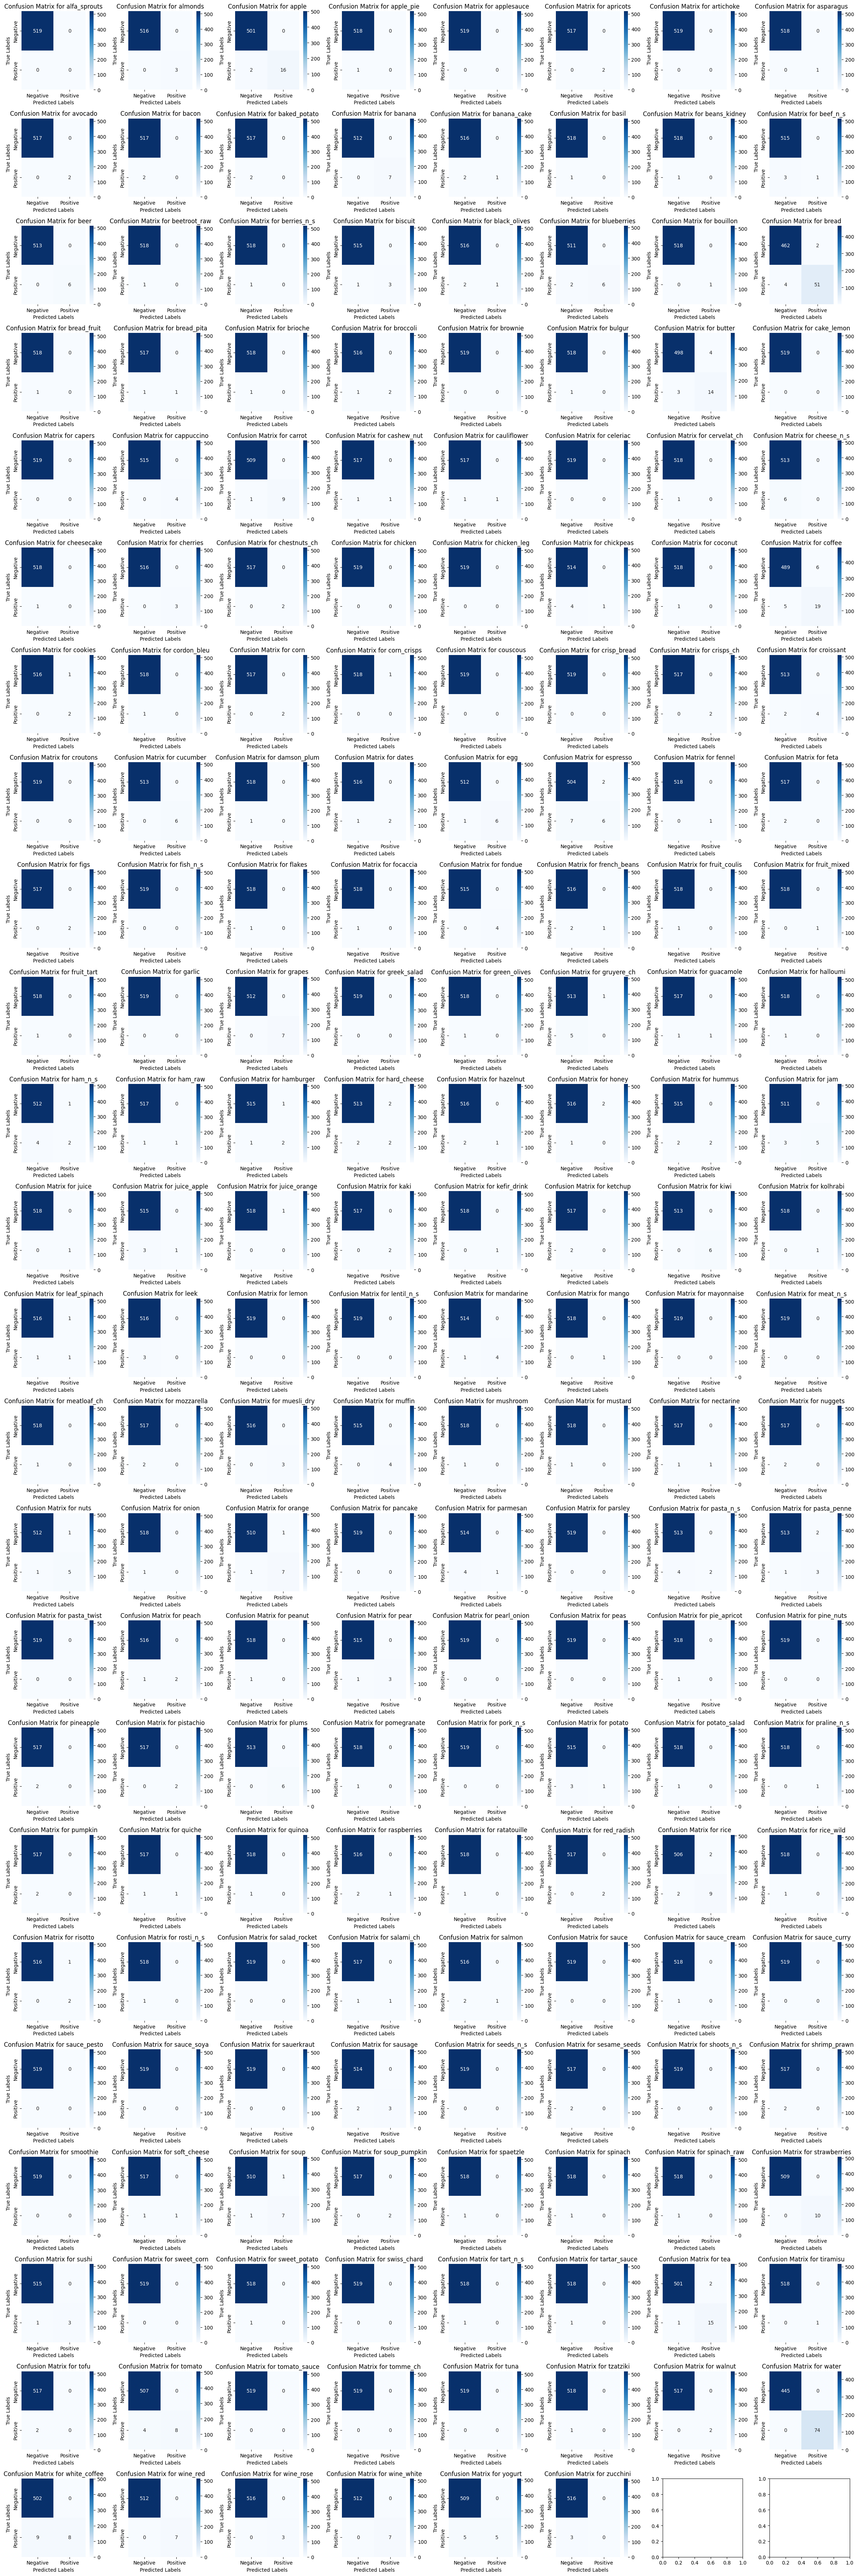

In [62]:
import seaborn as sns

def plot_confusion_matrix(cm, label, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix for {label}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.xaxis.set_ticklabels(['Negative', 'Positive'])
    ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# Plot the confusion matrix for each label
fig, axes = plt.subplots(nrows=24, ncols=8, figsize=(24, 72))
axes = axes.flatten()
for i, label in enumerate(dls.vocab):
    plot_confusion_matrix(cm[i], label, ax=axes[i])
plt.tight_layout()
plt.show()